In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io
from skimage import filters, morphology

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features
from seghub.vgg16_utils import get_vgg16_features_targets, get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_seg_forest, predict_seg_forest_single_image, predict_seg_forest, selfpredict_seg_forest_single_image, segment_seg_forest

In [117]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
print(shark_vid.shape)

(744, 480, 640, 3)


In [13]:
img = shark_vid[0] / 255
# img = img[:,:,0]
print(img.shape)

(480, 640, 3)


In [14]:
v = napari.view_image(img)

In [118]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
2480


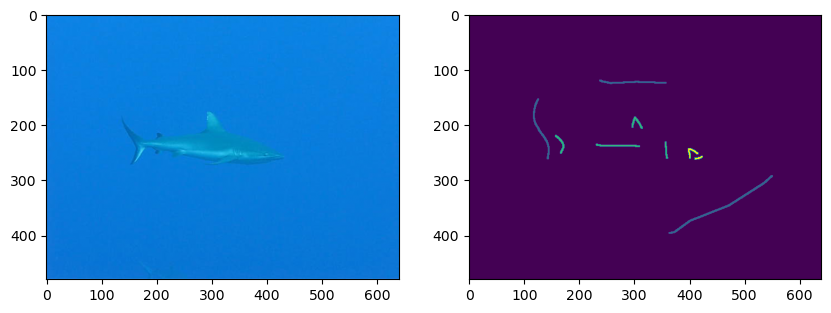

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(labels)

## VGG16 (Convpaint)

In [32]:
feature_space = get_vgg16_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(feature_space.shape)

(480, 640, 128)


In [33]:
# Because of edge problems in the current version of convpaint, we exclude the edge features
overall_means = np.mean(np.mean(feature_space, axis=0),axis=0)
feature_space[:5] = overall_means
feature_space[-5:] = overall_means
feature_space[:,:5] = overall_means
feature_space[:,-5:] = overall_means

In [34]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

(128, 480, 640)
(128, 480, 640)


In [27]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space VGG16")

<Image layer 'Feature Space VGG16 [2]' at 0x27c2466e130>

In [35]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


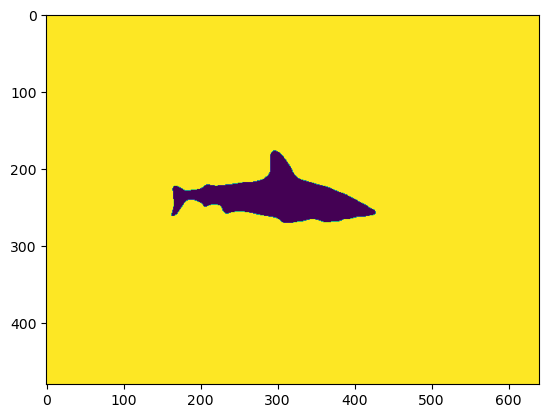

In [36]:
plt.imshow(kmeans_f)

In [37]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


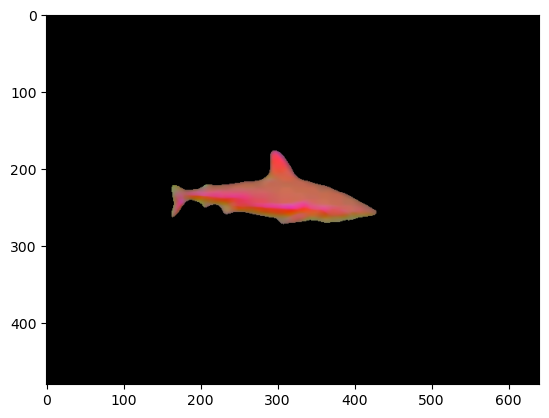

In [38]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

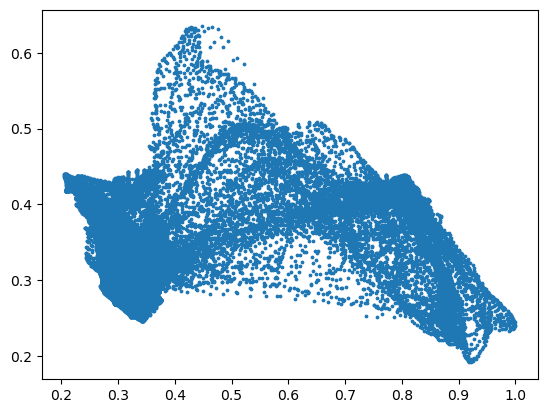

In [39]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [40]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


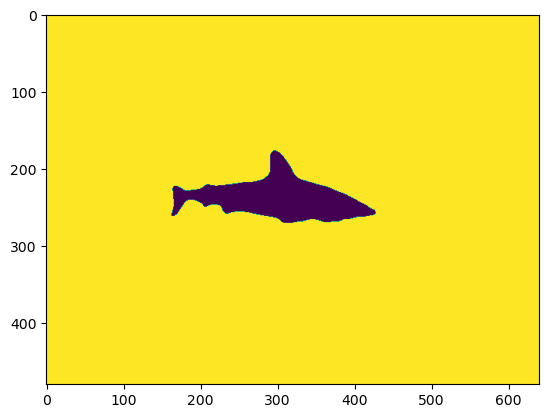

In [43]:
plt.imshow(kmeans_p)

In [44]:
annot_features, targets = get_vgg16_features_targets(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(2480, 128)
(2480,)


In [45]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


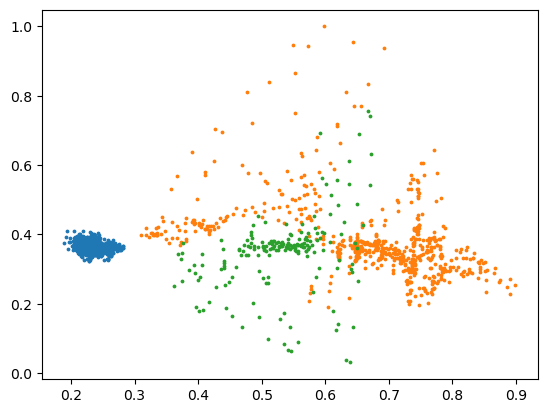

In [46]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [47]:
used_model = "s_r"
# used_model = "uni"

In [22]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [48]:
patch_features = get_dinov2_patch_features(img, dinov2_model=used_model)
print(patch_features.shape)

(1610, 384)


In [49]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False, dinov2_model=used_model)
print(pix_features.shape)

(307200, 384)


In [50]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False, dinov2_model=used_model)
print(feature_space.shape)

(480, 640, 384)


In [51]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

In [26]:
v.add_image(np.moveaxis(feature_space, -1, 0), name=f"Feature Space DINOv2 ({used_model})")

<Image layer 'Feature Space DINOv2 (s_r)' at 0x212c68a0e80>

In [52]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


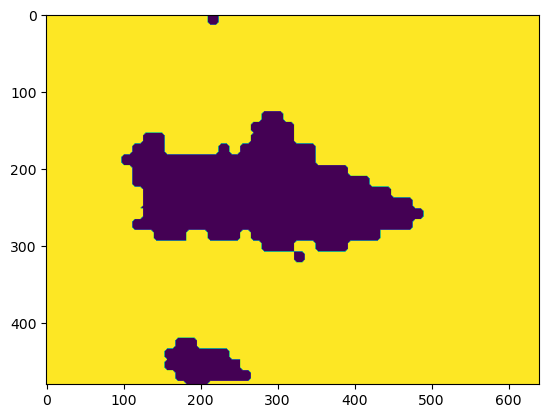

In [53]:
plt.imshow(kmeans_f)

In [54]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


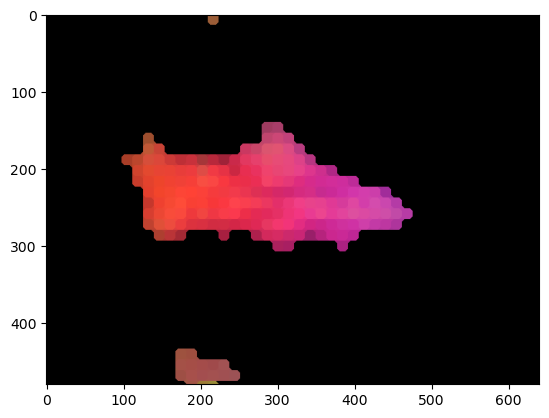

In [55]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.6
three_pc[pc_mask] = 0
plt.imshow(three_pc)

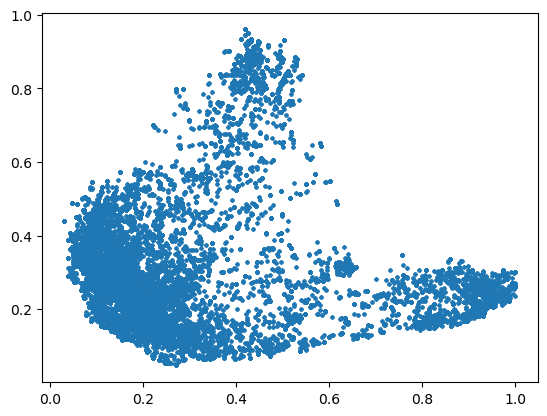

In [56]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [57]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


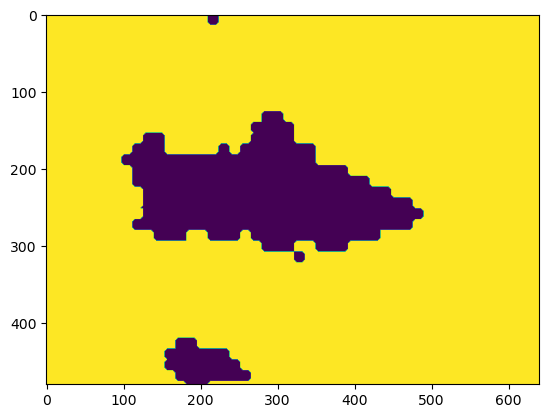

In [58]:
plt.imshow(kmeans_p)

In [59]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [60]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


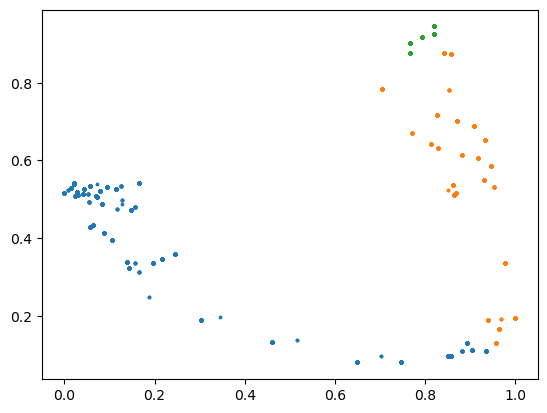

In [61]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [181]:
feature_space = get_ila_feature_space(img)
print(feature_space.shape)

(480, 640, 168)


In [63]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

In [38]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x212c6752b50>

In [182]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


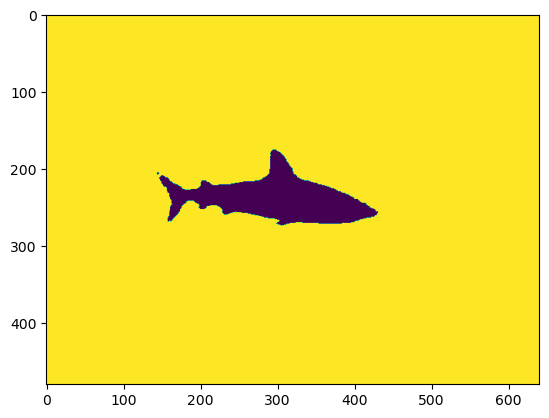

In [183]:
plt.imshow(kmeans_f)

In [184]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


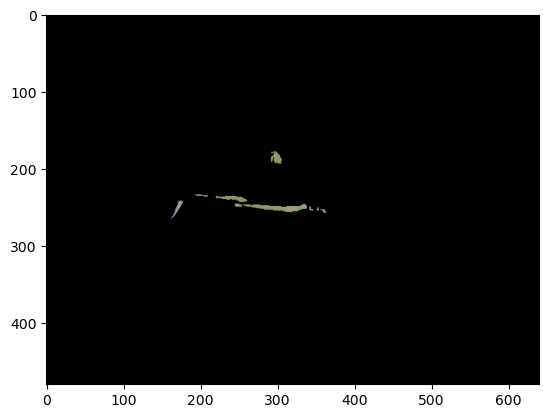

In [185]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

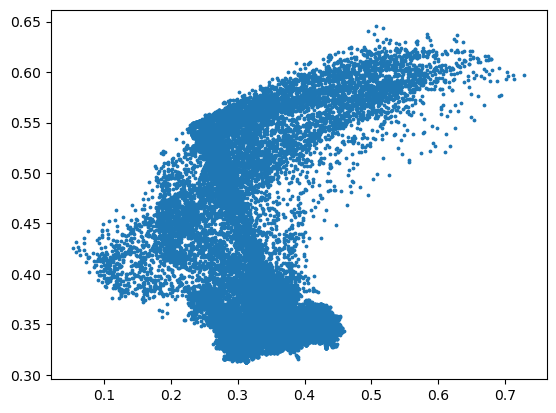

In [186]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [187]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


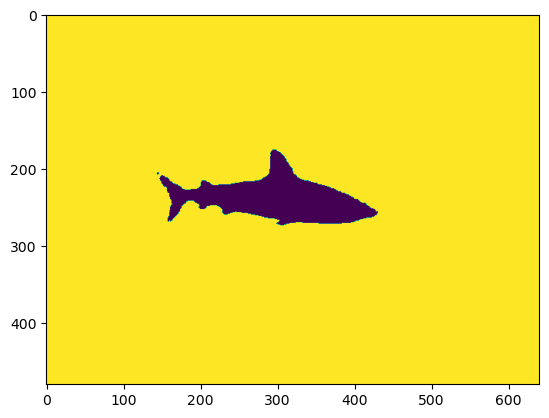

In [188]:
plt.imshow(kmeans_p)

In [189]:
annot_features, targets = get_ila_features_targets(img, labels)

In [190]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


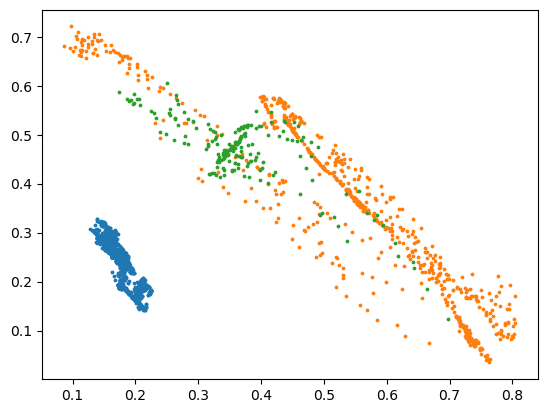

In [191]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [177]:
# features_func_train = get_vgg16_feature_space
# features_func_pred = get_vgg16_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_feature_space
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc_as_features": 0, "dinov2_model":"s_r"}
# features_func_train = get_ila_feature_space
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [50]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [134]:
rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [135]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


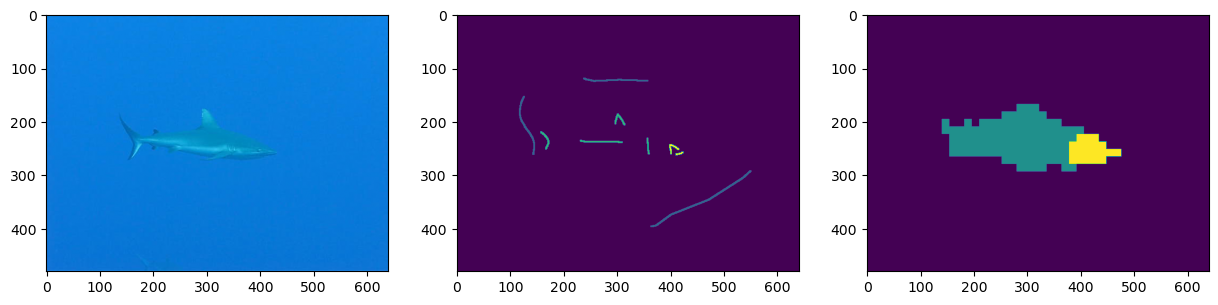

In [136]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(pred)

In [105]:
pred_vid = shark_vid.copy()/255
pred_vid = pred_vid[:40:4]

In [178]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/5 - estimated time left: NA
Predicting image 2/5 - estimated time left: 29.9 seconds
Predicting image 3/5 - estimated time left: 19.6 seconds
Predicting image 4/5 - estimated time left: 12.7 seconds
Predicting image 5/5 - estimated time left: 6.3 seconds


In [107]:
v2 = napari.view_image(pred_vid)
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x27c9a791190>

Use selfpredict function

In [179]:
selfpred = selfpredict_seg_forest_single_image(img, labels, features_func_train, features_cfg, random_state=0)

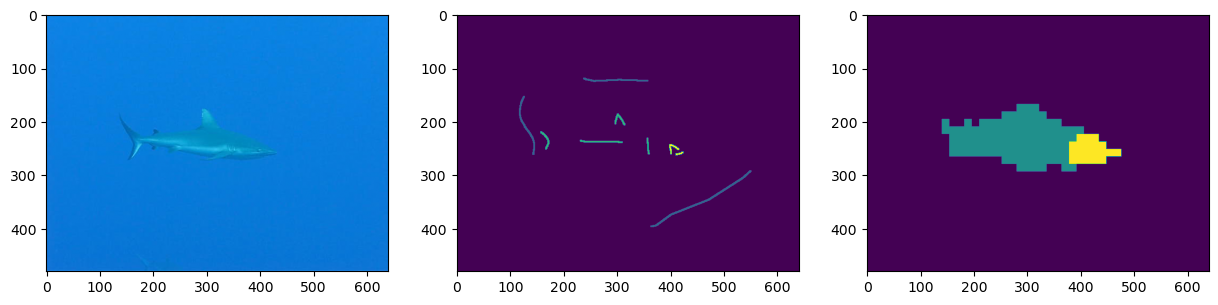

In [180]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(selfpred)

Use function to train and predict on different batches/movies

In [126]:
train_vid = [img]
train_labels = [labels]
pred_vid = shark_vid[100:105].copy()/255

In [174]:
pred_vid_seg = segment_seg_forest(train_vid, train_labels, pred_vid, features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA
Predicting image 1/5 - estimated time left: NA
Predicting image 2/5 - estimated time left: 21.0 seconds
Predicting image 3/5 - estimated time left: 19.9 seconds
Predicting image 4/5 - estimated time left: 14.6 seconds
Predicting image 5/5 - estimated time left: 7.3 seconds


In [175]:
v3 = napari.view_image(train_vid)
v3.add_labels(labels)
v3.add_image(pred_vid)
v3.add_labels(pred_vid_seg)

<Labels layer 'pred_vid_seg' at 0x27c95ecde80>